# Final Project
* data source
  * [LinkedIn Job Postings (2023-2024)](https://www.kaggle.com/datasets/arshkon/linkedin-job-postings)

In [1]:
import pandas as pd
import os
import psycopg2
import datetime

from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
# Connect to postgres DB
conn = psycopg2.connect(
    dbname=os.environ.get("DBNAME"),
    user=os.environ.get("USER"),
    password=os.environ.get("PASSWORD"),
    host=os.environ.get("HOST"),
    port=os.environ.get("PORT"),
)

In [4]:
# Open a cursor to perform database operations
cur = conn.cursor()

## Create Tables

In [ ]:
# Create benefits table
cur.execute("""
CREATE TABLE benefits (
    job_id BIGINT NOT NULL,
    inferred BOOLEAN NOT NULL,
    type VARCHAR(255) NOT NULL,
    PRIMARY KEY (job_id, type)
);
""")
conn.commit()

In [7]:
# Create job_industries table
cur.execute("""
CREATE TABLE job_industries (
    job_id BIGINT NOT NULL,
    industry_id INT NOT NULL,
    PRIMARY KEY (job_id, industry_id)
);
""")
conn.commit()

In [8]:
# Create job_skills table
cur.execute("""
CREATE TABLE job_skills (
    job_id BIGINT NOT NULL,
    skill_abr VARCHAR(10) NOT NULL,
    PRIMARY KEY (job_id, skill_abr)
);
""")
conn.commit()

In [9]:
# Create salaries table
cur.execute("""
CREATE TABLE salaries (
    salary_id SERIAL PRIMARY KEY,
    job_id BIGINT NOT NULL,
    max_salary NUMERIC(15, 2),
    med_salary NUMERIC(15, 2),
    min_salary NUMERIC(15, 2),
    pay_period VARCHAR(10) NOT NULL,
    currency VARCHAR(3) NOT NULL,
    compensation_type VARCHAR(20) NOT NULL
);
""")
conn.commit()

In [10]:
# Create industries table
cur.execute("""
CREATE TABLE industries (
    industry_id INT PRIMARY KEY,
    industry_name VARCHAR(255) NOT NULL
);
""")
conn.commit()

In [11]:
# Create skills table
cur.execute("""
CREATE TABLE skills (
    skill_abr VARCHAR(10) PRIMARY KEY,
    skill_name VARCHAR(255) NOT NULL
);
""")
conn.commit()

In [12]:
# create job_postings table
cur.execute("""
CREATE TABLE job_postings (
    job_id BIGINT PRIMARY KEY,
    company_name VARCHAR(255) NOT NULL,
    title VARCHAR(255) NOT NULL,
    description TEXT NOT NULL,
    max_salary NUMERIC(10, 2),
    pay_period VARCHAR(20),
    location VARCHAR(255),
    company_id BIGINT,
    views INT,
    med_salary NUMERIC(10, 2),
    min_salary NUMERIC(10, 2),
    formatted_work_type VARCHAR(50),
    applies INT,
    original_listed_time TIMESTAMP,
    remote_allowed BOOLEAN,
    job_posting_url VARCHAR(255),
    application_url VARCHAR(255),
    application_type VARCHAR(50),
    expiry TIMESTAMP,
    closed_time TIMESTAMP,
    formatted_experience_level VARCHAR(50),
    skills_desc TEXT,
    listed_time TIMESTAMP,
    posting_domain VARCHAR(255),
    sponsored BOOLEAN,
    work_type VARCHAR(50),
    currency VARCHAR(10),
    compensation_type VARCHAR(50),
    normalized_salary NUMERIC(10, 2),
    zip_code VARCHAR(10),
    fips VARCHAR(10)
);
""")
conn.commit()

In [13]:
# Create companies table
cur.execute("""
CREATE TABLE companies (
    company_id BIGINT PRIMARY KEY,
    name VARCHAR(255) NOT NULL,
    description TEXT,
    company_size INT,
    state VARCHAR(50),
    country VARCHAR(50),
    city VARCHAR(100),
    zip_code VARCHAR(20),
    address VARCHAR(255),
    url VARCHAR(255)
);
""")
conn.commit()

In [14]:
# Create company_industries table
cur.execute("""
CREATE TABLE company_industries (
    company_id BIGINT NOT NULL,
    industry VARCHAR(255) NOT NULL,
    PRIMARY KEY (company_id, industry)
);
""")
conn.commit()

In [15]:
# Create company_specialities table
cur.execute("""
CREATE TABLE company_specialities (
    company_id BIGINT NOT NULL,
    speciality VARCHAR(255) NOT NULL,
    PRIMARY KEY (company_id, speciality)
);
""")
conn.commit()

In [16]:
# Create employee_counts table
cur.execute("""
CREATE TABLE employee_counts (
    company_id BIGINT PRIMARY KEY,
    employee_count INT NOT NULL,
    follower_count INT NOT NULL,
    time_recorded TIMESTAMP NOT NULL
);
""")
conn.commit()

## Insert data to tables

In [ ]:
df = pd.read_csv("data/companies/companies.csv")
df['company_id'] = df['company_id'].fillna(-1)
df['company_size'] = df['company_size'].fillna(-1)
for idx, row in df.iterrows():
    try:
        cur.execute(
            """
            INSERT INTO companies (company_id, name, description, company_size, state, country, city, zip_code, address, url)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
            """,
            (int(row['company_id']), row['name'], row['description'], float(row['company_size']), row['state'], row['country'], row['city'], row['zip_code'][:20], row['address'], row['url'])
        )
        conn.commit()
    except Exception as e:
        conn.rollback()
        print(e)
        print(row)

In [40]:
df = pd.read_csv("data/companies/company_industries.csv")
for _, row in df.iterrows():
    try:
        cur.execute(
            """
            INSERT INTO company_industries (company_id, industry)
            VALUES (%s, %s)
            """,
            (row['company_id'], row['industry'])
        )
        conn.commit()
    except Exception as e:
        conn.rollback()
        print(e)
        print(row)

In [57]:
df = pd.read_csv("data/companies/company_specialities.csv")
for _, row in df.iterrows():
    try:
        cur.execute(
            """
            INSERT INTO company_specialities (company_id, speciality)
            VALUES (%s, %s)
            """,
            (row['company_id'], row['speciality'][:255])
        )
        conn.commit()
    except Exception as e:
            conn.rollback()
            print(e)
            print(row)

In [ ]:
df = pd.read_csv(f"data/companies/employee_counts.csv")
for _, row in df.iterrows():
    try:
        cur.execute(
            f"""
            INSERT INTO employee_counts (company_id, employee_count, follower_count, time_recorded)
            VALUES (%s, %s, %s, %s)
            """,
            (int(row['company_id']), int(row['employee_count']), int(row['follower_count']), datetime.datetime.fromtimestamp(row['time_recorded']))
        )
        conn.commit()
    except Exception as e:
            conn.rollback()
            print(e)
            print(row)

In [56]:
table_name = "benefits"
df = pd.read_csv(f"data/jobs/{table_name}.csv")
columns = list(df.columns)
for _, row in df.iterrows():
    try:
        cur.execute(
            f"""
            INSERT INTO {table_name} ({', '.join(columns)})
            VALUES ({', '.join(['%s'] * len(columns))})
            """,
            # (tuple(row[column] for column in columns))
            (row['job_id'], bool(row['inferred']), row['type'])
        )
        conn.commit()
    except Exception as e:
            conn.rollback()
            print(e)
            print(row)

In [67]:
table_name = "job_industries"
df = pd.read_csv(f"data/jobs/{table_name}.csv")
columns = list(df.columns)
for _, row in df.iterrows():
    try:
        cur.execute(
            f"""
            INSERT INTO {table_name} ({', '.join(columns)})
            VALUES ({', '.join(['%s'] * len(columns))})
            """,
            (tuple(int(row[column]) for column in columns))
        )
        conn.commit()
    except Exception as e:
            conn.rollback()
            print(e)
            print(row)

In [68]:
table_name = "job_skills"
df = pd.read_csv(f"data/jobs/{table_name}.csv")
columns = list(df.columns)
for _, row in df.iterrows():
    try:
        cur.execute(
            f"""
            INSERT INTO {table_name} ({', '.join(columns)})
            VALUES ({', '.join(['%s'] * len(columns))})
            """,
            (int(row[columns[0]]), row[columns[1]])
        )
        conn.commit()
    except Exception as e:
            conn.rollback()
            print(e)
            print(row)

In [69]:
table_name = "salaries"
df = pd.read_csv(f"data/jobs/{table_name}.csv")
columns = list(df.columns)
for _, row in df.iterrows():
    try:
        cur.execute(
            f"""
            INSERT INTO {table_name} ({', '.join(columns)})
            VALUES ({', '.join(['%s'] * len(columns))})
            """,
            (tuple(row[column] for column in columns))
        )
        conn.commit()
    except Exception as e:
            conn.rollback()
            print(e)
            print(row)

In [70]:
table_name = "industries"
df = pd.read_csv(f"data/mappings/{table_name}.csv")
columns = list(df.columns)
for _, row in df.iterrows():
    try:
        cur.execute(
            f"""
            INSERT INTO {table_name} ({', '.join(columns)})
            VALUES ({', '.join(['%s'] * len(columns))})
            """,
            (tuple(row[column] for column in columns))
        )
        conn.commit()
    except Exception as e:
            conn.rollback()
            print(e)
            print(row)

In [71]:
table_name = "skills"
df = pd.read_csv(f"data/mappings/{table_name}.csv")
columns = list(df.columns)
for _, row in df.iterrows():
    try:
        cur.execute(
            f"""
            INSERT INTO {table_name} ({', '.join(columns)})
            VALUES ({', '.join(['%s'] * len(columns))})
            """,
            (tuple(row[column] for column in columns))
        )
        conn.commit()
    except Exception as e:
            conn.rollback()
            print(e)
            print(row)

In [ ]:
table_name = "job_postings"
df = pd.read_csv(f"data/postings.csv")
columns = list(df.columns)
for _, row in df.iterrows():
    try:
        cur.execute(
            """
            INSERT INTO job_postings (
                job_id, company_name, title, description, max_salary, pay_period,
                location, company_id, views, med_salary, min_salary, formatted_work_type,
                applies, original_listed_time, remote_allowed, job_posting_url,
                application_url, application_type, expiry, closed_time,
                formatted_experience_level, skills_desc, listed_time, posting_domain,
                sponsored, work_type, currency, compensation_type, normalized_salary,
                zip_code, fips
            ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
            """,
            (
                int(row['job_id']) if pd.notnull(row['job_id']) else -1,
                str(row['company_name'])[:255],
                str(row['title'])[:255],
                row['description'],
                float(row['max_salary']) if pd.notnull(row['max_salary']) else -1,
                str(row['pay_period'])[:20],
                str(row['location'])[:255],
                int(row['company_id']) if pd.notnull(row['company_id']) else -1,
                int(row['views']) if pd.notnull(row['views']) else -1,
                float(row['med_salary']) if pd.notnull(row['med_salary']) else -1,
                float(row['min_salary']) if pd.notnull(row['min_salary']) else -1,
                str(row['formatted_work_type'])[:50],
                int(row['applies']) if pd.notnull(row['applies']) else -1,
                datetime.datetime.fromtimestamp(float(str(row['original_listed_time'])[:10])) if pd.notnull(row['original_listed_time']) else None,
                bool(row['remote_allowed']),
                str(row['job_posting_url'])[:255],
                str(row['application_url'])[:255],
                str(row['application_type'])[:50],
                datetime.datetime.fromtimestamp(float(str(row['expiry'])[:10])) if pd.notnull(row['expiry']) else None,
                datetime.datetime.fromtimestamp(float(str(row['closed_time'])[:10])) if pd.notnull(row['closed_time']) else None,
                str(row['formatted_experience_level'])[:50],
                row['skills_desc'],
                datetime.datetime.fromtimestamp(float(str(row['listed_time'])[:10])) if pd.notnull(row['listed_time']) else None,
                str(row['posting_domain'])[:255],
                bool(row['sponsored']),
                str(row['work_type'])[:50],
                str(row['currency'])[:10],
                str(row['compensation_type'])[:50],
                float(row['normalized_salary']) if pd.notnull(row['normalized_salary']) else -1,
                str(row['zip_code'])[:10],
                str(row['fips'])[:10]
            )
        )
        conn.commit()
    except Exception as e:
            conn.rollback()
            print(e)
            print(row)


## Visualization

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

### Percentage of jobs by type of occupation

The percentage of jobs in the US that include software, developer, engineer, or data in the title.

The word "engineer" is more common because of its abstract nature.

In [6]:
cur.execute("""
SELECT
  COUNT(CASE WHEN title LIKE '%Software%' OR title LIKE '%software%' THEN 1 END) AS software_count,
  COUNT(CASE WHEN title LIKE '%Developer%' OR title LIKE '%developer%' THEN 1 END) AS developer_count,
  COUNT(CASE WHEN title LIKE '%Engineer%' OR title LIKE '%engineer%' THEN 1 END) AS engineer_count,
  COUNT(CASE WHEN title LIKE '%Data%' OR title LIKE '%data%' THEN 1 END) AS data_count
FROM
  job_postings
LEFT JOIN companies USING (company_id)
WHERE
  original_listed_time IS NOT NULL
  AND country = 'US'
""")
tuples_list = cur.fetchall()
df = pd.DataFrame(tuples_list, columns=['software', 'developer', 'engineer', 'data'])


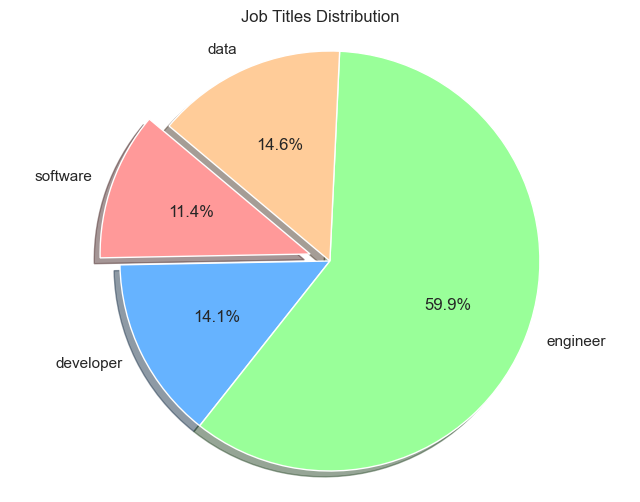

In [7]:
# Set the style
sns.set(style="whitegrid")

# Data for the pie chart
labels = df.columns
sizes = df.iloc[0].values
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']  # Colors for each section
explode = (0.1, 0, 0, 0)  # explode the 1st slice (Software)

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Title
plt.title('Job Titles Distribution')
plt.show()

### Relationship between company size and salary

Company size and salary in the engineering profession are plotted on a scatter plot.
I expected that salaries would increase as company size increased, but no trend was observed.

In [8]:
cur.execute("""
SELECT
  title,
  company_size,
  normalized_salary
FROM
  job_postings
LEFT JOIN companies USING (company_id)
WHERE
  original_listed_time IS NOT NULL
  AND country = 'US'
  AND (
    title LIKE '%Engineer%'
    OR title LIKE '%engineer%'
  )
  AND med_salary > 0
  AND company_size > 0
  ORDER BY original_listed_time DESC;
""")
tuples_list = cur.fetchall()
df = pd.DataFrame(tuples_list, columns=['title', 'company_size', 'normalized_salary'])

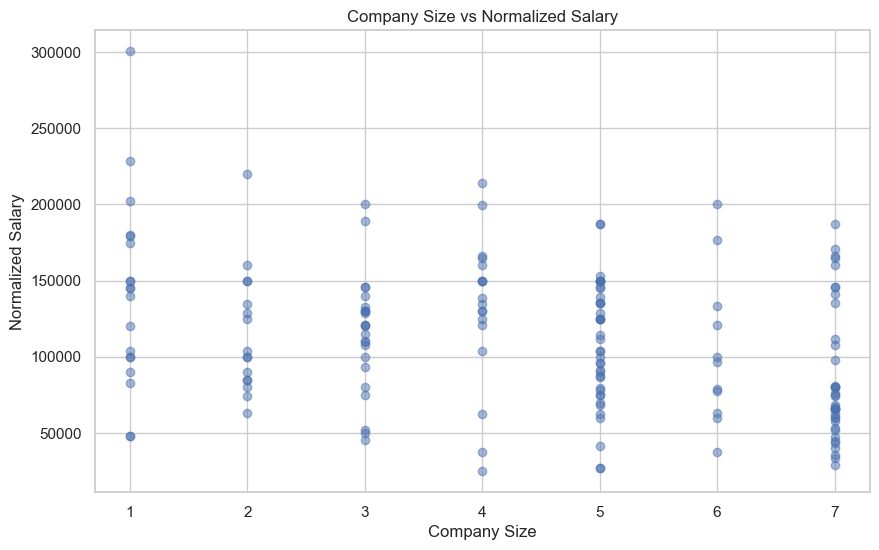

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(df['company_size'], df['normalized_salary'], alpha=0.5)
plt.title('Company Size vs Normalized Salary')
plt.xlabel('Company Size')
plt.ylabel('Normalized Salary')
plt.grid(True)
plt.show()

### Relationship between Industry and Salary

The relationship between industry and salary was visualized on a bar chart with the top 10 highest salaries.
Salaries in Wholesale and Real Estate Agents and Brokers are by far the highest, while salaries in the other industries do not show much difference.

In [10]:
cur.execute("""
SELECT
  industry_name,
  AVG(normalized_salary) AS average_normalized_salary
FROM
  job_postings
LEFT JOIN companies USING (company_id)
LEFT JOIN job_industries USING (job_id)
LEFT JOIN industries USING (industry_id)
WHERE
  country = 'US'
  AND normalized_salary > 0
  AND industry_name IS NOT NULL
GROUP BY
  industry_name
ORDER BY 2 DESC
LIMIT 10
""")
tuples_list = cur.fetchall()
df = pd.DataFrame(tuples_list, columns=['industry_name', 'average_normalized_salary'])

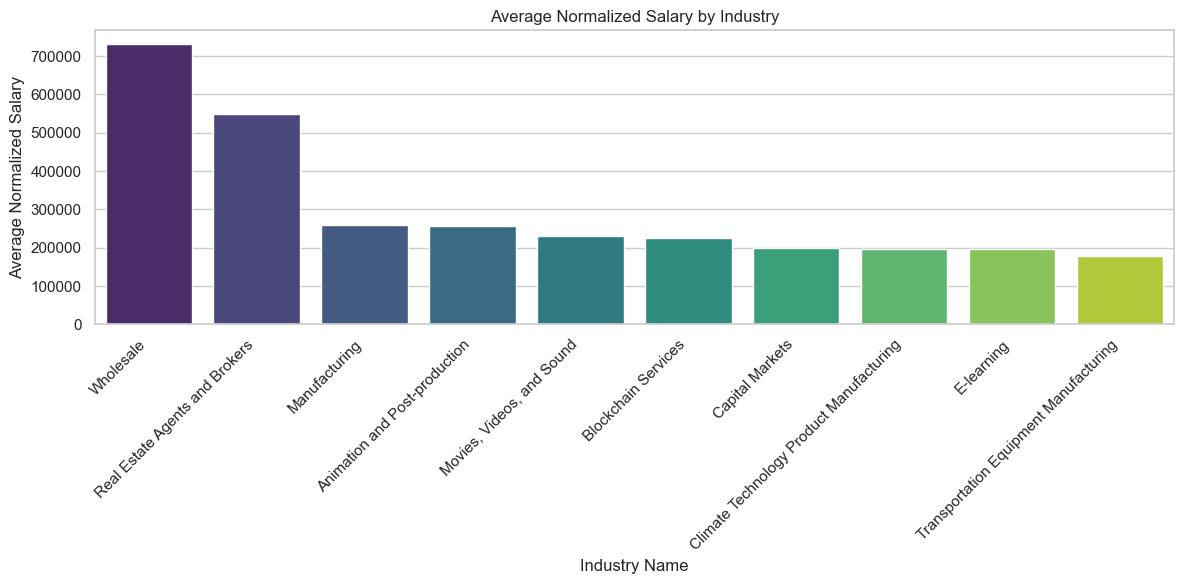

In [11]:
plt.figure(figsize=(12, 6))
sns.barplot(x='industry_name', y='average_normalized_salary', data=df, hue='industry_name', palette='viridis', legend=False)
plt.title('Average Normalized Salary by Industry')
plt.xlabel('Industry Name')
plt.ylabel('Average Normalized Salary')
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()